# Timing comparisons for lme4 and MixedModels

The [`lme4`](https://github.com/lme4/lme4) package for [R](http://R-project.org) and the [`MixedModels`](https://github.com/dmbates/MixedModels.jl) for [Julia](http://JuliaLang.org) both provide functions to fit linear and generalized linear mixed-effects models.

This notebook provides an analysis of the results of fitting several model/dataset combinations in both of these systems.  The versions of the packages and the configuration of the computer are:

- __Julia version__: 0.4.6 (2016-06-19 17:16 UTC)
- __MixedModels version__: 0.5.5
- __R version__: 3.3.1 (2016-06-21)
- __lme4 version__: 1.1.13
- __CPU:__ Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz
- __OS:__ Linux
- __CPU_CORES__: 48
- __WORD_SIZE:__ 64-bit
- __BLAS:__ libopenblas64 (Julia)
- __memory:__ 125.808 GB


In [1]:
using DataFrames, DataFramesMeta, Gadfly 

    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /home/bates/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.DataArray, AbstractArray) at /home/bates/.julia/v0.4/DataArrays/src/operators.jl:276.
To fix, define 
    +(DataArrays.DataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.
    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /home/bates/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.AbstractDataArray, AbstractArray) at /home/bates/.julia/v0.4/DataArrays/src/operators.jl:300.
To fix, define 
    +(DataArrays.AbstractDataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.


In [2]:
results = readtable("results50.csv");

In [3]:
show(names(results))

[:dsmodel,:n,:nopt,:p,:q,:optimizer,:objective,:elapsed,:neval]

These columns are:
- `dsname`: a string constructed from the dataset name and the model specification
- `n`: the number of observations in the data set
- `nopt`: the dimension of the vector $\theta$ over which the optimization takes place
- `p`: the dimension of the fixed-effects parameter vector, $\beta$
- `optimizer`: the name of the optimizer used
- `objective`: the minimum value of the objective achieved
- `elapsed`: elapsed time (seconds)
- `neval`: number of evaluations until convergence is declared

## Comparing the accuracy of the optimizers

For optimization problems such as considered here we cannot "prove" convergence.  The best we can do is to use several different optimizers on the same problem and assume that the minimum achieved by any of the optimizers is close to the actual minimum.  We then must determine if the results of the other optimizers are "close enough" to this value.  For this we calculate `:excess`, the difference between the achieved objective value and the minimum over the all the optimizers applied to that `dsmodel`.

This objective is negative twice the log-likelihood, the quantity used in a likelihood ratio test comparing nested models.  This leads us to define "close enough" as within 0.001 of the minimum over all the optimizers.

In [4]:
excess = @by(results, :dsmodel, optimizer = :optimizer, excess = :objective .- minimum(:objective));
results = join(results, excess, on = [:dsmodel,:optimizer]);
@by(results, :optimizer, nmod = length(:excess),
    nfail = sum(:excess .> 0.001), 
    maxexcess = maximum(:excess))

,optimizer,nmod,nfail,maxexcess
1,LN_BOBYQA,50,1,0.024007960950257257
2,LN_COBYLA,49,2,0.02372480147096212
3,LN_NELDERMEAD,43,4,571.3482102986018
4,LN_SBPLX,49,2,4.963593877149833
5,NLOPT_LN_BOBYQA,50,2,0.0305885131310788
6,NLOPT_LN_COBYLA,49,9,45.08287241923972
7,NLOPT_LN_NELDERMEAD,43,2,571.3482104094292
8,NLOPT_LN_SBPLX,49,2,4.96360512209867
9,Nelder_Mead,43,3,331.52563495002687
10,bobyqa,49,2,18.22487979023117


The optimizers whose names begin with "LN\_" are user with `lmm`, the others with `lmer`.  The default for `lmm` is `LN_BOBYQA`, the implementation of Powell's "__B__ounded __O__ptimization __BY Q__uadratic __O__ptimization" algorithm in Steven Johnson's [`NLopt`](https://github.com/stevengj/nlopt) package.  Those whose names begin with `NLOPT_LN_` are `R` optimizers that use same optimization library. Those whose names begin with `optimx:` are from the `optimx` package from R.  The `bobyqa` and `Nelder_Mead` optimizers are built-in to the [`lme4`](https://github.com/lme4/lme4) package for R.

Only `optimx:nlminb` has an unblemished record using this criterion and `LN_BOBYQA` failed once with an excess objective of 0.024.  While above the threshold being used, this is not a terribly alarming failue.

The various implementations of the Nelder-Mead optimizer failed more frequently and sometimes failed badly.  It is interesting that the same underlying code for the `LN_NELDERMEAD` and `NLOPT_LN_NELDERMEAD` optimizers fails a different number of times in `lmm` and `lmer`.  The evaluation of the objective is done in slightly different ways in the Julia and R implementations and the values may not be identical.  Nevertheless this shows an undesirable fragility in the algorithm.  We will also see below that the Nelder-Mead algorithm is unacceptably slow.

The `bobyqa` and `optimx:bobyqa` algorithms provide similar results, which we would expect given that the underlying optimization code is the same (Powell's original Fortran code) and the evaluation of the objective function is being done in R in both cases.  Nevertheless on at least one problem the excess objective is unacceptably large.  The `NLOPT_LN_BOBYQA` optimizer, using Steven Johnson's implementation of Powell's algorithm, is better behaved.

The same evaluation by model provides

In [23]:
modelexcess = @by(results, :dsmodel, nopt = :nopt[1], nfit = length(:excess),
    nfail = sum(:excess .> 0.05), 
    maxexcess = maximum(:excess))

,dsmodel,nopt,nfit,nfail,maxexcess
1,Alfalfa:1+A*B+(1|G),1,14,0,9.568086767330897e-8
2,Animal:1+(1|G)+(1|H),2,14,0,1.7131050533691905e-7
3,Assay:1+A+B*C+(1|G)+(1|H),2,14,3,0.05941755072529986
4,AvgDailyGain:1+A*U+(1|G),1,14,0,1.0651787007986968e-7
5,AvgDailyGain:1+A+U+(1|G),1,14,0,8.188084663629525e-7
6,BIB:1+A*U+(1|G),1,14,0,1.0574984798950027e-7
7,Bond:1+A+(1|G),1,14,0,7.685343916818965e-8
8,Chem97:1+(1|G)+(1|H),2,14,0,0.00011188595090061426
9,Chem97:1+U+(1|G)+(1|H),2,14,0,0.0005652161489706486
10,Cultivation:1+A*B+(1|G),1,14,0,7.671658863728226e-9


In [24]:
@where(modelexcess, :nfail .> 2)

,dsmodel,nopt,nfit,nfail,maxexcess
1,Assay:1+A+B*C+(1|G)+(1|H),2,14,3,0.05941755072529986
2,gb12:1+S+T+U+V+W+X+Z+((1+S+U+W)|G)+((1+S+T+V)|H),20,11,5,0.8955019967434055
3,kb07:1+S+T+U+V+W+X+Z+((1+S+T+U+V+W+X+Z)|G)+((1+S+T+U+V+W+X+Z)|H),72,11,3,4.96360512209867
4,paulsim:1+S+T+U+(1|G)+(0+S|G),2,14,4,571.3482104094292


Regarding the one failure of `LN_BOBYQA`, it was on a model fit to the `kb07` data and requiring a constrained nonlinear optimization with respect to 72 parameters.  This is unusual as all the other problems involve 20 or fewer parameters.

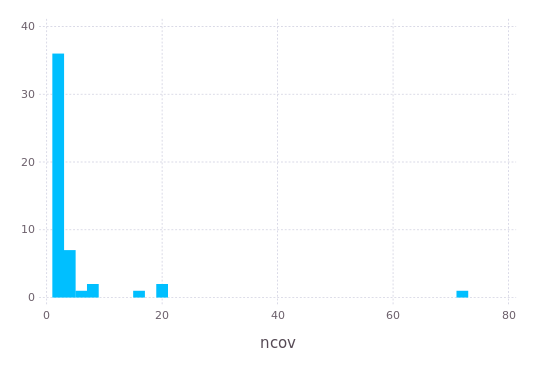

In [7]:
plot(@by(results, :dsmodel, ncov = unique(:nopt)), x = "ncov",
  Geom.histogram)

This particular model is hopelessly overparameterized with a very flat log-likelihood surface.  Such overparameterized models will inevitably converge to singular estimates of the covariance matrices for the random effects. These are local minima on the boundary of the allowable parameter space.  It happens in this case that one optimizer takes a slightly different path and ends up at a local minimum with a lower objective value than the local minimum to which most of the others converge.

In [8]:
@where(results, :nopt .> 20)

,dsmodel,n,nopt,p,q,optimizer,objective,elapsed,neval,excess
1,kb07:1+S+T+U+V+W+X+Z+((1+S+T+U+V+W+X+Z)|G)+((1+S+T+U+V+W+X+Z)|H),1790,72,8,448:256,LN_BOBYQA,28586.341621161664,16.045582265,1949,0.024007960950257257
2,kb07:1+S+T+U+V+W+X+Z+((1+S+T+U+V+W+X+Z)|G)+((1+S+T+U+V+W+X+Z)|H),1790,72,8,448:256,LN_COBYLA,28586.341338002185,1127.007904242,129098,0.02372480147096212
3,kb07:1+S+T+U+V+W+X+Z+((1+S+T+U+V+W+X+Z)|G)+((1+S+T+U+V+W+X+Z)|H),1790,72,8,448:256,LN_SBPLX,28591.281207077864,135.8195995,16903,4.963593877149833
4,kb07:1+S+T+U+V+W+X+Z+((1+S+T+U+V+W+X+Z)|G)+((1+S+T+U+V+W+X+Z)|H),1790,72,8,448:256,NLOPT_LN_BOBYQA,28586.348201713845,32.673,1535,0.0305885131310788
5,kb07:1+S+T+U+V+W+X+Z+((1+S+T+U+V+W+X+Z)|G)+((1+S+T+U+V+W+X+Z)|H),1790,72,8,448:256,NLOPT_LN_COBYLA,28586.320496452074,513.199,24585,0.0028832513598899823
6,kb07:1+S+T+U+V+W+X+Z+((1+S+T+U+V+W+X+Z)|G)+((1+S+T+U+V+W+X+Z)|H),1790,72,8,448:256,NLOPT_LN_SBPLX,28591.281218322812,421.246,8851,4.96360512209867
7,kb07:1+S+T+U+V+W+X+Z+((1+S+T+U+V+W+X+Z)|G)+((1+S+T+U+V+W+X+Z)|H),1790,72,8,448:256,bobyqa,28586.317613200714,318.717,15265,0.0
8,kb07:1+S+T+U+V+W+X+Z+((1+S+T+U+V+W+X+Z)|G)+((1+S+T+U+V+W+X+Z)|H),1790,72,8,448:256,optimx:L-BFGS-B,28586.317776241674,174.617,6,0.00016304096061503515
9,kb07:1+S+T+U+V+W+X+Z+((1+S+T+U+V+W+X+Z)|G)+((1+S+T+U+V+W+X+Z)|H),1790,72,8,448:256,optimx:bobyqa,28586.317613200714,323.417,NA,0.0
10,kb07:1+S+T+U+V+W+X+Z+((1+S+T+U+V+W+X+Z)|G)+((1+S+T+U+V+W+X+Z)|H),1790,72,8,448:256,optimx:nlminb,28586.317992963635,431.309,20108,0.00037976292151142843


To simplify comparisons we will omit this outlier.

In [9]:
results49 = @where(results, :nopt .< 50);
@by(results49, :optimizer, maxexcess = maximum(:excess))

,optimizer,maxexcess
1,LN_BOBYQA,1.798651646822691e-5
2,LN_COBYLA,0.008445000654319301
3,LN_NELDERMEAD,571.3482102986018
4,LN_SBPLX,0.821957186994041
5,NLOPT_LN_BOBYQA,0.004379900172352791
6,NLOPT_LN_COBYLA,45.08287241923972
7,NLOPT_LN_NELDERMEAD,571.3482104094292
8,NLOPT_LN_SBPLX,0.8221875324697976
9,Nelder_Mead,331.52563495002687
10,bobyqa,18.22487979023117


## Comparing the speed of the optimizers

The elapsed times cover a wide range and, of course, are very different for different problems. 

In [10]:
@by(results49, :dsmodel, minelapsed = minimum(:elapsed), maxelapsed = maximum(:elapsed))

,dsmodel,minelapsed,maxelapsed
1,Alfalfa:1+A*B+(1|G),0.000584173,0.192
2,Animal:1+(1|G)+(1|H),0.000518281,0.193
3,Assay:1+A+B*C+(1|G)+(1|H),0.001576767,0.204
4,AvgDailyGain:1+A*U+(1|G),0.000515179,0.189
5,AvgDailyGain:1+A+U+(1|G),0.000439551,0.188
6,BIB:1+A*U+(1|G),0.000541229,0.189
7,Bond:1+A+(1|G),0.000392641,0.188
8,Chem97:1+(1|G)+(1|H),0.011816775,0.821
9,Chem97:1+U+(1|G)+(1|H),0.012795451,1.114
10,Cultivation:1+A*B+(1|G),0.000482953,0.194


To compare speeds within problems we determine the ratio of the elapsed time to the minimum elapsed time of those optimizers that converged.  For non-convergence the function returns `Inf`.

In [16]:
function ratioelapsed(objective, elapsed)
    minobj = minimum(objective)
    adjtime = map((o, e) -> (o - minobj) < 0.05 ? e : Inf, objective, elapsed)
    adjtime ./ minimum(adjtime)
end    

ratioelapsed (generic function with 1 method)

Consider this simple example

In [17]:
dyestuff = @where(results, :dsmodel .== "Dyestuff:1+(1|G)")

,dsmodel,n,nopt,p,q,optimizer,objective,elapsed,neval,excess
1,Dyestuff:1+(1|G),30,1,1,6,LN_BOBYQA,327.32705988113594,0.00035047,18,8.526512829121202e-13
2,Dyestuff:1+(1|G),30,1,1,6,LN_COBYLA,327.32705988279287,0.000376721,27,1.657781467656605e-9
3,Dyestuff:1+(1|G),30,1,1,6,LN_NELDERMEAD,327.327059902227,0.000362475,28,2.1091921098559396e-8
4,Dyestuff:1+(1|G),30,1,1,6,LN_SBPLX,327.327059902227,0.000420738,43,2.1091921098559396e-8
5,Dyestuff:1+(1|G),30,1,1,6,NLOPT_LN_BOBYQA,327.3270598811366,0.018,18,1.5347723092418164e-12
6,Dyestuff:1+(1|G),30,1,1,6,NLOPT_LN_COBYLA,327.32705988183795,0.018,22,7.028688742138911e-10
7,Dyestuff:1+(1|G),30,1,1,6,NLOPT_LN_NELDERMEAD,327.32706101376345,0.018,22,1.1326283697599138e-6
8,Dyestuff:1+(1|G),30,1,1,6,NLOPT_LN_SBPLX,327.32706101376345,0.019,30,1.1326283697599138e-6
9,Dyestuff:1+(1|G),30,1,1,6,Nelder_Mead,327.32705988116606,0.019,36,3.097966327914037e-11
10,Dyestuff:1+(1|G),30,1,1,6,bobyqa,327.3270598811351,0.016,18,0.0


In [18]:
showcompact(@with(dyestuff, ratioelapsed(:objective, :elapsed)))

[1.0,1.0749,1.03425,1.2005,51.3596,51.3596,51.3596,54.2129,54.2129,45.653,302.451,302.451,302.451,550.689]

In [19]:
ratio = @by(results, :dsmodel, optimizer = :optimizer, ratio = ratioelapsed(:objective, :elapsed));
@by(ratio, :optimizer, gmean = geomean(filter(isfinite, convert(Array, :ratio))))

,optimizer,gmean
1,LN_BOBYQA,1.022683281071162
2,LN_COBYLA,2.930674049791652
3,LN_NELDERMEAD,1.3447201092781906
4,LN_SBPLX,1.8070973287167644
5,NLOPT_LN_BOBYQA,18.658735753465432
6,NLOPT_LN_COBYLA,28.38828301441561
7,NLOPT_LN_NELDERMEAD,28.627960415967962
8,NLOPT_LN_SBPLX,29.03680475359228
9,Nelder_Mead,33.07945401397076
10,bobyqa,24.53827279950281


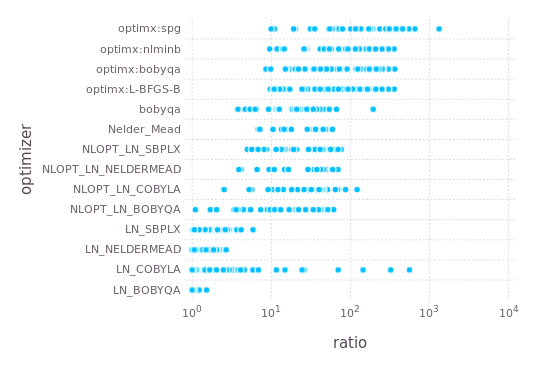

In [20]:
plot(ratio, x = "ratio", y = "optimizer", Geom.point, Scale.x_log10)

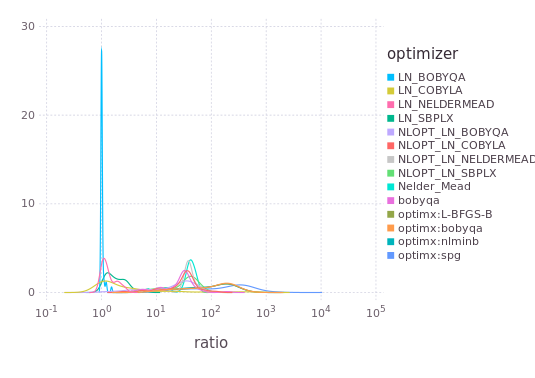

In [21]:
plot(@where(ratio, isfinite(:ratio)) , x = "ratio", color = "optimizer", Geom.density, Scale.x_log10)

In [22]:
countmap(convert(Array, @where(ratio, :ratio .== 1)[:optimizer]))

Dict{UTF8String,Int64} with 3 entries:
  "LN_NELDERMEAD" => 3
  "LN_COBYLA"     => 7
  "LN_BOBYQA"     => 40